### Chris Ribaudo
### EN 625 701

# Introduction

The purpose of this notebook is to investigate and delve deep into branching processes, -- which is a branch of statistics that looks at populations over many generations -- ways to model them, and shortcomings of these modeling efforts.

We will begin by describing what a branching process is, then introduce the mathematical notation used throughout this notebook, and then we will dive into some code to simulate and model various branching processes and better undrestand the strengths and shortcomings of various modeling techniques regarding them. 

The aim of this notebook is to gain some intuition and understanding of the various statistical estimators involved in  branching processes, and when it is most appropriate to use each one.

# Branching Processes

A branching process describes a the statistical study of populations over multiple generations, where the reproduction of individuals from one generation to the next follows some statistical distribution.

Some of the questions that one may ask when studying a branching process are
- What is the underlying distribution(s) that govern the reproduction rate of individuals?
- What is the expected number of offspring for a given individual?
- What will happen as a population evolves over multiple generations? Will they grow or become extinct or stabilize?
- Can we model the population across multiple generations to predict future trends?

This notebook will focus on the last three questions posed here, though there are plenty of others that could also be investigated.

To begin let's formally define a branching process and the notation that will be used throughout this notebook.

# Mathematical Definitions and Notations and Background

Let $Z_n$ be a random variable representing population of a group in the $n$th generation, with $Z_0$ being the initial population. Unless otherwise specified $Z_0$ can be assumed to be 1. For simplicity, we will assume that here.

Each individual reproduces to have $x$ offspring according to the probability mass function describing the random variable $Y$. Let $X_{in}$ represent the number of offspring that individual $i$ in generation $n$ produces. Then we have that $Z_{n+1} = \sum_{i = 1}^{Z_n} X_{in}$.

We can observe that $Z_1 \sim Y$ if $Z_0 = 1$.

One natural question to ask is what is the expected number of offspring any given individual would have, i.e. what is $EY$? Throughout this investigation we will sometimes refer to $EY$ as $m$.

Now that the notation has been specified, we can begin to introduce some important results covered in class, beginning with the simplest branching process, the Glaton-Watson Branching Process.

# The Traditional Galton-Watson Branching Process

In the traditional Galton-Watson Branching Process, each individaul reproduces according to the same probability distirbution independently of each other, across all generations.

Mathematically we can say this the following way. Let $EY = m$ as mentioned before. Let each $X_{in}$ reproduce according to the common discrete probability distribution representing the random variable $Y$, with each $X_{in}$ being independent of each other. i.e. each $X_{in}$ is i.i.d. and $E X_{in} = EY = m$.

Then one can conclude, as does Ferris [1]
$$E Z_n = (EY)^n = m^n$$

Moreover one can study the asymptotic behavior of the populations of these generations and conclude that
$$
\lim_{n \rightarrow \infty} Z_n = \left\{
    \begin{split}
        0 & \text{ if } m < 1 \\
        Z_0 & \text{ if } m = 1 \\
        \infty & \text{ if } m > 1
    \end{split}
    \right.
$$

These cases are known as the subcritical, critical, and supercritical cases respectively.

Now that we have defined our notation and some important early results for the Traditional Galton-Watson Branching Process, let's simulate some of these processes for various probability distributions and investigate how the populations evolve over time to better ground our understanding of these simulations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Given a probability mass function will sample it to get the number of offspring an individual has
def get_individual_offspring(pmf, *args):
    return pmf(*args)

# Gets the number of offspring for each parent in a generation.
def get_generation_offspring(n_parents, pmf, *args):
    n_offspring = 0
    offspring = []
    for _ in range(n_parents):
        n_kids = get_individual_offspring(pmf, *args)
        offspring.append(n_kids)
        n_offspring += n_kids
    return offspring, n_offspring

def simulate_n_generations(n_generations, starting_amt, allow_extinction, get_generation_offspring_func, pmf, *args):
    generation_counts = [[1 for _ in range(starting_amt)]]
    for _ in range(n_generations):
        n_parents = sum(generation_counts[-1])
        offspring, n_offspring = get_generation_offspring_func(n_parents, pmf, *args)
        if not allow_extinction:
            while n_offspring < 1:
                offspring, n_offspring = get_generation_offspring_func(n_parents, pmf, *args)
        generation_counts.append(offspring)
        
    return generation_counts

We will begin by defining our probability mass function for the reproduction of individuals to be that of a geometric random variable with probability $p$. i.e.
$$ Y \sim Ge(p)$$

We will investigate all three of the supercritical, critical, and subcritical cases.

Because $EY = \frac{1 - p}{p}$, we have that 
- $p = 0.5 \Rightarrow EY = 0.5$ (critical case)
- $p > 0.5 \Rightarrow EY < 1$   (subcritical case)
- $p < 0.5 \Rightarrow EY > 1$   (supercritical case)

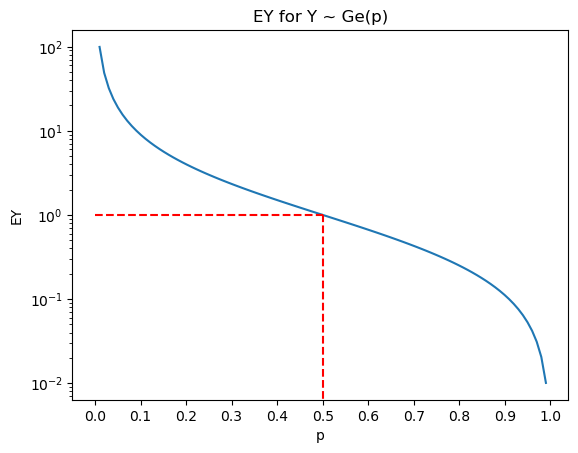

In [3]:
fig, ax = plt.subplots()

p = np.linspace(0.01, 0.99, 98)
ey = (1 - p) / p

ax.plot(p, ey)
ax.hlines(y=1, xmin=0, xmax=0.5, color='red', linestyle='--')
ax.vlines(x=0.5, ymin=0, ymax=1, color='red', linestyle='--')
ax.semilogy()
ax.set_xticks(np.linspace(0, 1, 11))

ax.set_ylabel('EY')
ax.set_xlabel('p')
ax.set_title('EY for Y ~ Ge(p)')

plt.savefig('EGe(p).png')
plt.show()

So we can examine the supercritical, critical, and subcritical case when $p = 0.4, 0.5, 0.6$ respectively.

Let's simulate these scenarios now, doing 20 simulations for each of the three cases.

## Simulating Traditional Galton-Watson Branching Process
### Geometric Distributions

In [4]:
# np random geometric is actually the first success distribution
# subtract by 1 to make it geometric
geometric_pmf = lambda p: np.random.geometric(p) - 1
n_generations = 30
n_simulations = 20

# supercritical, critical, subcritical cases
probabilities = [0.4, 0.5, 0.6]
traditional_geometric_results = {}
for p in probabilities:
    traditional_geometric_results[p] = []
    for sample in tqdm(range(n_simulations)):
        generation_counts = simulate_n_generations(n_generations, 1, True, get_generation_offspring, geometric_pmf, p)
        traditional_geometric_results[p].append(generation_counts)

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 16313.90it/s]


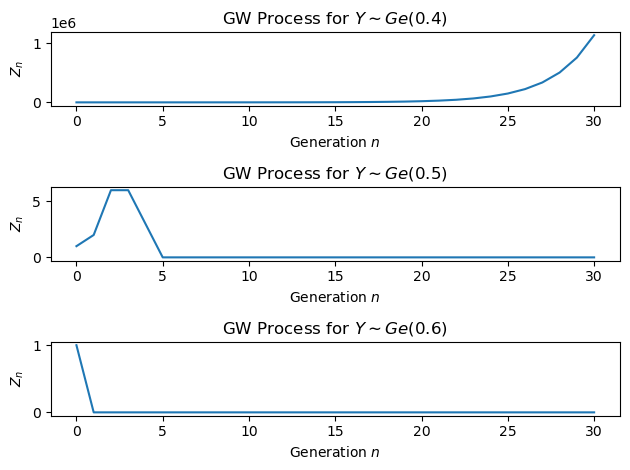

In [8]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, p in zip(axs.flatten(), probabilities):
    sample = np.random.randint(n_simulations)
    populations = [sum(traditional_geometric_results[p][sample][i]) for i in range(n_generations+1)]
    ax.plot(populations)
    
    ax.set_title(f'GW Process for $Y \sim Ge({p:0.1f})$')
    ax.set_ylabel('$Z_{n}$')
    ax.set_xlabel('Generation $n$')

plt.savefig('GW_traditional_process_geometric.png')
plt.show()

We can see that in the supercritical case the population explodes exponentially, whereas in the subcritical case the population tends to 0. In the critical case the population goes to 0 as well experimentally.

In the real world though we are often given data and have to try to find a model to best fit the data. So if we were to instead observe some random data coming from a branching process, how could we model how the population will evolve over time?

That is what we will investigate next.

## Maximum Likelihood Estimates

In the Traditional Galton Watson Branching Process described above, the asymptotic behavior of the population over each generation is entirely determined from the average number of offspring each individual has for each generation. Namely
$$ EZ_n = (EY)^n = m^n$$

So if we can obtain an estimate for $m$ then we can have a rudimentary understanding of the distribution underpinning the branching process and model its behavior into the future.

Keiding and Lauritzan showed that the maximum likelihood estimator $\hat{m}$ for $m = EY$ is given by [2]
$$ \frac{Z_1 + Z_2 + \ldots + Z_n}{Z_0 + Z_1 + \ldots + Z_{n - 1}}$$
i.e. the total number of children divided by the total number of parents.

We can apply this to each of our simulations to see how accurately these predictions match up.

In [9]:
parent_counts = {}
child_counts = {}
for p in probabilities:
    parent_counts[p] = []
    child_counts[p] = []
    for simulation in range(n_simulations):
        generation_counts = []
        for generation in range(n_generations):
            generation_counts.append(sum(traditional_geometric_results[p][simulation][generation]))
        parent_counts[p].append(sum(generation_counts[:-1]))
        child_counts[p].append(sum(generation_counts[1:]))
        
estimators = {p: [child_counts[p][i] / parent_counts[p][i] for i in range(n_simulations)] for p in probabilities}
expected_values = {p: (1-p)/p for p in probabilities}

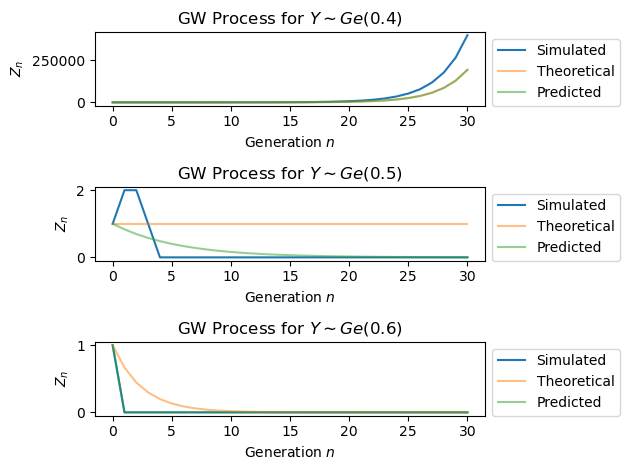

In [13]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, p in zip(axs.flatten(), probabilities):
    sample = np.random.randint(n_simulations)
    populations = [sum(traditional_geometric_results[p][sample][i]) for i in range(n_generations+1)]
    ax.plot(populations, label='Simulated')
    
    x = np.arange(n_generations+1)
    theoretical = list(map(lambda n: expected_values[p]**n, x))
    predicted = list(map(lambda n: estimators[p][sample]**n, x))
    
    ax.plot(theoretical, label='Theoretical', alpha=0.5)
    ax.plot(predicted, label='Predicted', alpha=0.5)
    
    ax.set_title(f'GW Process for $Y \sim Ge({p:0.1f})$')
    ax.set_ylabel('$Z_{n}$')
    ax.set_xlabel('Generation $n$')
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig('GW_traditional_process_geometric_with_predictions.png')
plt.show()

In reality though the Branching Process does not follow these simple rules. 

Oftentimes the reproduction of offspring in a further generation is dependent on the total number of individuals in the current generation, this can be seen in biology where there are limited resources so only a finite number of individuals can be supported by an environment.

Another consideration is that of immigration. Somtimes there are multiple factors contributing to the number of individuals in a generation, and not solely reproduction from the previous generation. In modeling the number of individauls in a country or city this is the case as there are people who can migrate into (and out of) the city, contributing to the overall population in a given generation.

Another?

Let's examine each of these scenarios and see the difference in Maximum Likelihood Estimator (MLE) performance and what remedies can be done to produce a more effective model for estimating the true mean value in each of these scenarios.

# Finite Populations

The first scenario we will examine will be those in which an infinite population is not possible (or is supported with probability 0). One example of this is in with modeling species populations in biology. 

In such scenarios, as in many real life scenarios, the number of descendents in a subsequent generation is dependent on the population of the current generation. i.e. the mean offspring is now a function of the current population, $m(z)$. One famous model [3] is the Beverton-Holt model. Here we have that
$$ m(z) = \frac{2K}{K + z} $$
where $K$ is the carrying capacity of the environment for the population, i.e. the number of individuals it can support sustainably.

To simulate a model like this we will assume our population follows the law of binary splitting, meaning that each individual can either have 0 or 2 offspring. They have 2 offspring with probability $\frac{m(z)}{2}$ and have 0 with the remaining probability.

i.e.
$$ 
\begin{split}
    &P(Y = 2 | z) = \frac{m(z)}{2} = \frac{K}{K + z} \\
    &P(Y = 0 | z) = 1 - P(Y = 2) = \frac{z}{K + z}
\end{split}
$$

One can easily verify that $E\left(Y | z\right) = m(z) = \frac{2K}{K + z}$ so in fact $m(z)$ is always the expected, or mean number of offspring for a given individual.

Let's generate 20 simulations of this process for 3 different carrying capacities of $K$.

In [14]:
# Making generation offspring dependent on the number of parents
def get_parent_dependent_generation_offspring(n_parents, pmf, *args):
    n_offspring = 0
    offspring = []
    for _ in range(n_parents):
        n_kids = get_individual_offspring(pmf, n_parents, *args)
        offspring.append(n_kids)
        n_offspring += n_kids
    return offspring, n_offspring

def finite_pop_binary_split_pmf(current_pop, K):
    return 2 if np.random.rand() < (2*K / (K + current_pop) / 2) else 0

In [15]:
carrying_capacities = [50, 100, 500]
finite_population_results = {}
for K in carrying_capacities:
    finite_population_results[K] = []
    for sample in tqdm(range(n_simulations)):
        generation_counts = simulate_n_generations(n_generations, 1, True, get_parent_dependent_generation_offspring, finite_pop_binary_split_pmf, K)
        finite_population_results[K].append(generation_counts)

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 80.05it/s]


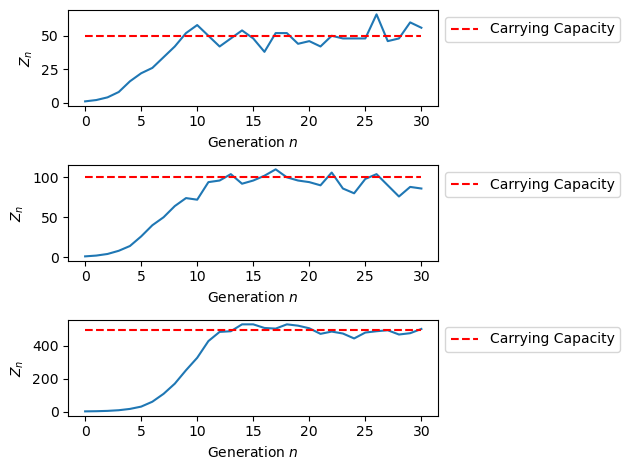

In [16]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, K in zip(axs.flatten(), carrying_capacities):
    sample = np.random.randint(n_simulations)
    populations = [sum(finite_population_results[K][sample][i]) for i in range(n_generations+1)]
    ax.plot(populations)
    ax.hlines(y=K, xmin=0, xmax=n_generations, color='red', linestyle='--', label='Carrying Capacity')
    
    ax.set_xlabel('Generation $n$')
    ax.set_ylabel('$Z_n$')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('simulated_finite_pop.png')
plt.show()

We can see that regardless of the carrying capacity the population iniitally grows exponentially but then seems to hover around the carrying capacity.

This can be further seen by increasing the number of generations we let the branching process carry out for to 300 instead of 30.

In [17]:
n_generations = 300
finite_population_results = {}
for K in carrying_capacities:
    finite_population_results[K] = []
    for sample in tqdm(range(n_simulations)):
        generation_counts = simulate_n_generations(n_generations, 1, True, get_parent_dependent_generation_offspring, finite_pop_binary_split_pmf, K)
        finite_population_results[K].append(generation_counts)

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.83it/s]


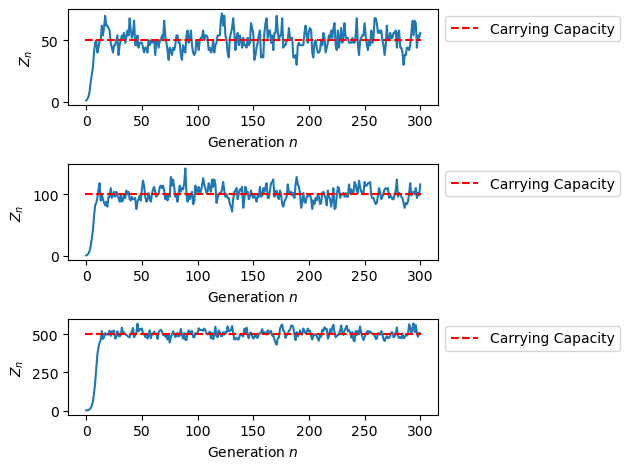

In [18]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, K in zip(axs.flatten(), carrying_capacities):    
    sample = np.random.randint(n_simulations)
    populations = [sum(finite_population_results[K][sample][i]) for i in range(n_generations+1)]
    ax.plot(populations)
    ax.hlines(y=K, xmin=-1, xmax=n_generations+1, color='red', linestyle='--', label='Carrying Capacity')

    ax.set_xlabel('Generation $n$')
    ax.set_ylabel('$Z_n$')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('simulated_finite_pop_300gen.png')
plt.show()

Here we know that the probability distribution for the number of offspring is dependent on the current population, so our MLE for estimating the mean number of offspring should also reflect that.

The MLE we obtained for the Traditional Galton-Watson Branching Process though is not dependent on the current population, so it would not make sense to use it. It would also be innapropriate to use it as the Traditional Galton-Watson Branching Process assumes that each offspring's reproduction probabilities is i.i.d, whereas here that is clearly not the case as at each generation it is different depending on the current genration's population.

To illustrate this, let's apply the method of estimating $m$ via $\hat{m}$ as done in the traditional GW process, where we assume that the mean offspring is independent of the current population. i.e. using
$$ \hat{m} = \frac{Z_1 + Z_2 + \ldots + Z_n}{Z_0 + Z_1 + \ldots + Z_{n - 1}}$$

In [19]:
parent_counts = {}
child_counts = {}
for K in carrying_capacities:
    parent_counts[K] = []
    child_counts[K] = []
    for simulation in range(n_simulations):
        generation_counts = []
        for generation in range(n_generations):
            generation_counts.append(sum(finite_population_results[K][simulation][generation]))
        parent_counts[K].append(sum(generation_counts[:-1]))
        child_counts[K].append(sum(generation_counts[1:]))
        
estimators = {K: [child_counts[K][i] / parent_counts[K][i] for i in range(n_simulations)] for K in carrying_capacities}

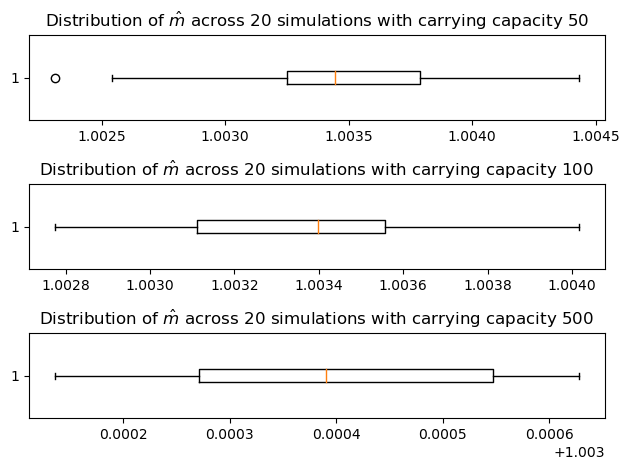

In [20]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, K in zip(axs.flatten(), carrying_capacities):
    ax.boxplot(estimators[K], vert=False)
    
    ax.set_title(f'Distribution of $\hat{{m}}$ across {n_simulations} simulations with carrying capacity {K}')

plt.savefig('finite_pop_estimator_distribution.png')
plt.show()

We can see that it is consistently estimating it to be very slightly above 1, which makes sense given that the population does grow from the beginning but it's growth flattens out once it hits the carrying capacity, so overall while there is exponential growth it is very small.

The issue with this estimation and this model is that it incorrectly assumes there will be exponential growth, as it esimtates $m > 1$, and will not reflect the phenomena of this carrying capacity. Instead it will assume the population grows to infinity.

We can see this if we plot the simulated populations and their theoretical predictions based on these estimates $\hat{m}$.

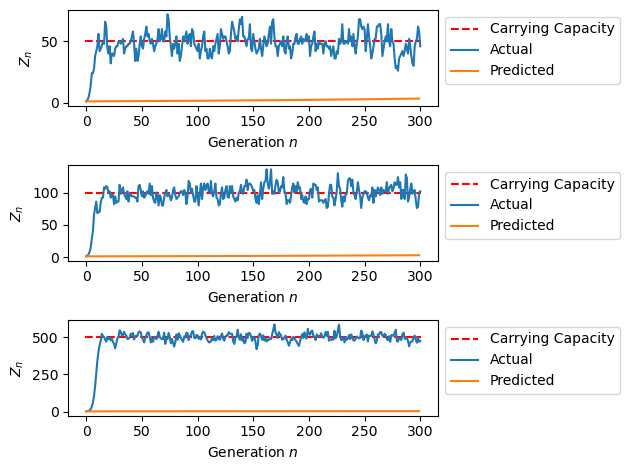

In [21]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, K in zip(axs.flatten(), carrying_capacities):
    ax.hlines(y=K, xmin=-1, xmax=n_generations+1, color='red', linestyle='--', label='Carrying Capacity')
    
    sample = np.random.randint(n_simulations)
    populations = [sum(finite_population_results[K][sample][i]) for i in range(n_generations+1)]
    ax.plot(populations, label='Actual')
    
    m = estimators[K][sample]
    predicted = [m**i for i in range(n_generations)]
    ax.plot(predicted, label='Predicted')
    
    ax.set_xlabel('Generation $n$')
    ax.set_ylabel('$Z_n$')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('finite_pop_with_predictions.png')
plt.show()

We can see that the growth is too slow early on in this model. And if we lengthen out the predictions we will see that the traditional GW model showing exponential growth begins to incorrectly model populations above the carrying capacity.

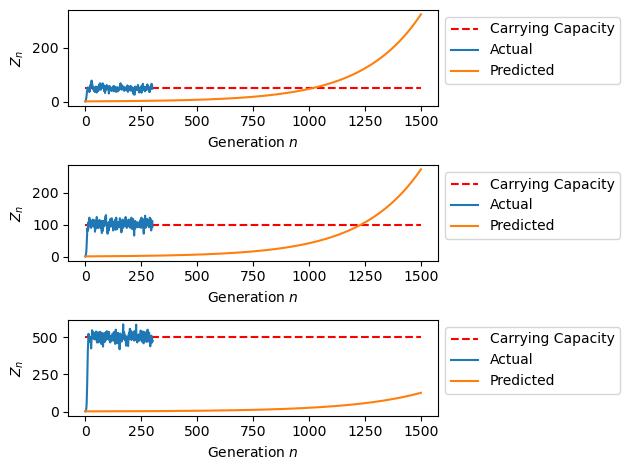

In [22]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, K in zip(axs.flatten(), carrying_capacities):
    ax.hlines(y=K, xmin=-1, xmax=n_generations*5+1, color='red', linestyle='--', label='Carrying Capacity')
    
    sample = np.random.randint(n_simulations)
    populations = [sum(finite_population_results[K][sample][i]) for i in range(n_generations+1)]
    ax.plot(populations, label='Actual')
    
    m = estimators[K][sample]
    predicted = [m**i for i in range(n_generations*5)]
    ax.plot(predicted, label='Predicted')
    
    ax.set_xlabel('Generation $n$')
    ax.set_ylabel('$Z_n$')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('finite_pop_with_bad_predictions.png')
plt.show()

In [5] they find the maximum likelihood estimator of the offspring mean, dependent on the current population $z$ is given by
$$ \hat{m}(z) = \frac{\sum_{i = 1}^{n}Z_i I(Z_{i - 1} = z)}{z\sum_{i = 1}^{n}I(Z_{i - 1} = z)} $$
where $I$ is the indicator function.

While it may not seem immediately obvious, this is actually an analagous extension to the original estimator $\hat{m}$ from the Traditional GW Branching Process.

Recall that the original estimator $\hat{m}$ was given by
$$ \hat{m} = \frac{\sum_{i = 1}^{n} Z_i}{\sum_{i = 0}^{n - 1} Z_i} $$
which is the total number of children divided by the total number of parents across all generations.

The estimator dependent on $z$ here, which is $\hat{m}(z)$ is the same, except it is the total number of children **when there were $z$ parents** divided by the number of parents **when there were $z$ parents** (which is obviously $z$).

So they are the same, except that the one dependent on $z$ only uses information obtained when the population was $z$ to inform what will happen at those same points in time, whereas the original estimator $\hat{m}$ uses all observations to inform it's estimation, regardless of what the current population is.

Now that we intuitively understand the estimator $\hat{m}(z)$ and why it is a natural extension to the original $\hat{m}$ that is now dependent on the current population $z$, we can obtain a new model, and more accurate model using this new estimator $\hat{m}(z)$  that is especially suited for this scenario where there is a carrying capacity of the population that it tends to hover around. Let's do that here.

In [23]:
generation_counts = {}
for K in carrying_capacities:
    generation_counts[K] = {}
    for simulation in range(n_simulations):
        generation_counts[K][simulation] = []
        for generation in range(n_generations):
            generation_counts[K][simulation].append(sum(finite_population_results[K][simulation][generation]))
            
def obtain_estimate(generation_counts):
    m = {}
    for population in generation_counts[:-1]:
        numerator = 0
        denominator = 0
        for i in range(1, len(generation_counts)):
            indicator = 1 if generation_counts[i-1] == population else 0
            numerator += generation_counts[i] * indicator
            denominator += indicator
        m[population] = numerator / (denominator * population) if population > 0 else 0
    return m
        
estimators = {}
for K in carrying_capacities:
    estimators[K] = {}
    for simulation in range(n_simulations):
        estimators[K][simulation] = obtain_estimate(generation_counts[K][simulation])

The theoretical number offspring for each generation $i$ is the expected number of offspring per parent, multiplied by the number of parents. i.e.
$$Z_{i - 1} * m(z)(Z_{i - 1})$$

So similarly the predicted number of offspring using the estimator $\hat{m}(z)$ would be
$$ Z_{i - 1} * \hat{m}(z)(Z_{i - 1})$$

Let's plot this trend with the actual simulated trends now, as well as the theoretical expected trends.

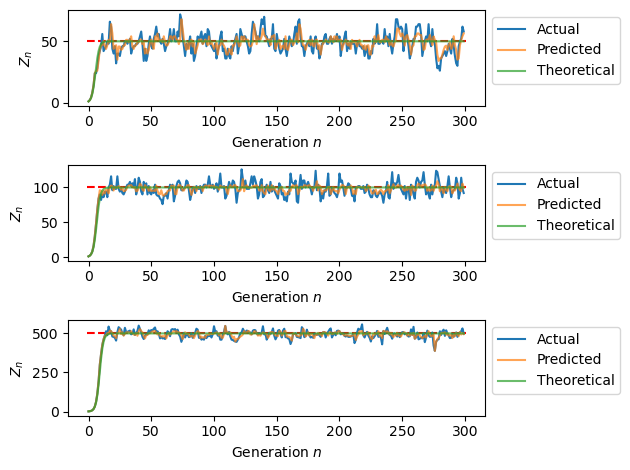

In [26]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, K in zip(axs.flatten(), carrying_capacities):
    ax.hlines(y=K, xmin=-1, xmax=n_generations+1, color='red', linestyle='--')
    
    sample = np.random.randint(n_simulations)
    populations = [sum(finite_population_results[K][sample][i]) for i in range(n_generations)]
    ax.plot(populations, label='Actual')
    
    predicted = [1] + [i * estimators[K][sample][i] for i in populations[:-1]]
    ax.plot(predicted, label='Predicted', alpha=0.7)
    
    theoretical = [1]
    for _ in range(len(predicted) - 1):
        theoretical.append((2*K / (K + theoretical[-1]))*theoretical[-1])
    ax.plot(theoretical, label='Theoretical', alpha=0.7)
    
    ax.set_xlabel('Generation $n$')
    ax.set_ylabel('$Z_n$')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('finite_pop_with_good_predictions.png')
plt.show()

We can see that the predicted values using the estimator $\hat{m}(z)$ line up very closely with the actual values in the simulation, as well as the theoretical values, all of which hover around the carrying capacity! Showing that $\hat{m}(z)$ is a much more accurate model for the finite population branching process, than the $\hat{m}$ estimator used for the traditional GW branching process.

This is a huge benefit because this is often the case in real world scenarios, especially when modeling populations of species in an ecosystem. Many species survive around some carrying capacity for hundreds or thousands of years and don't exponentially grow or decay, barring some outside event (such as a meteor or other extinction event). With this technique we can more succesfully model these types of populations and branching processes over time that we previously wouldn't have been able to do with only a traditional branching process estimator.

One downside to using this method however is that because we are only using points when the population for a generation is $z$ to inform our prediction for how the population will evolve for a generation with that same population, our model may be overfit to this case, or may not have sufficient data to model the system entirely. Scarcity of data in this scenario can be an issue which is something to be aware of.

# Immigration

Now we will examine situations in which a population isn't just growing merely by reproducing, but it is also experiencing external immigration to boost its population each generation as well. One obvious example of this is in the populations of cities or countries, which experience population growth through births and also through immigration.

In such scenarios, the population of the next generation is now the result of two processes: reproduction and immigration, so we can model it as the following system:
$$
Z_{n+1} = \sum_{i = 1}^{Z_n} X_{in} + Q_{n+1}
$$

where we are introducing the new random variable $Q_n$, which represents the number of immigrants coming into the population in generation $n + 1$.

Let's simulate this situation. To do so let's assume that each individual reproduces according to a poisson distribution with parameter $\lambda = 1.1$, and that immigration instead follows a geometric distribution with parameter $p = 0.2$. So we have that
$$
Y \sim Po(1.1) \quad \text{and} \quad Q \sim Ge(0.2)
$$

Let's generate 20 simulations as we have done before.

In [138]:
# Gets the number of offspring for each parent in a generation.
def get_generation_offspring_immigration(n_parents, pmf_reproduction, pmg_immigration, *args):
    n_offspring = 0
    offspring = []
    for _ in range(n_parents):
        n_kids = get_individual_offspring(pmf_reproduction, *args)
        offspring.append(n_kids)
        n_offspring += n_kids
    n_immigrants = get_individual_offspring(pmf_immigration)
    return offspring, n_offspring, n_immigrants

# Simulates populations for n generations
def simulate_n_generations_immigration(n_generations, starting_amt, allow_extinction, get_generation_offspring_func, pmf_reproduction, pmf_immigration, *args):
    generation_counts = [[1 for _ in range(starting_amt)]]
    offspring_counts = {}
    immigration_counts = {}
    for _ in range(n_generations):
        n_parents = sum(generation_counts[-1])
        offspring, n_offspring, n_immigrants = get_generation_offspring_func(n_parents, pmf_reproduction, pmf_immigration, *args)
        if not allow_extinction:
            while n_offspring < 1:
                offspring, n_offspring, n_immigrants = get_generation_offspring_func(n_parents, pmf_reproduction, pmf_immigration, *args)
        
        generation_counts.append(offspring + [n_immigrants])
        for n_kids in offspring:
            try:
                offspring_counts[n_kids] += 1
            except:
                offspring_counts[n_kids] = 1
        try:
            immigration_counts[n_immigrants] += 1
        except:
            immigration_counts[n_immigrants] = 1
    
    # only want parent generations up to second to last
    for n_kids in offspring:
        offspring_counts[n_kids] -= 1
    return generation_counts, offspring_counts, immigration_counts

In [139]:
# define probability distributions for reproduction and immigration
pmf_reproduction = lambda: np.random.poisson(1.1)
pmf_immigration = lambda: np.random.geometric(0.2)

n_generations = 30

immigration_population_results = []
for sample in tqdm(range(n_simulations)):
    generation_counts, offspring_counts, immigration_counts = simulate_n_generations_immigration(n_generations, 1, True, get_generation_offspring_immigration, pmf_reproduction, pmf_immigration)
    immigration_population_results.append((generation_counts, offspring_counts, immigration_counts))

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 59.48it/s]


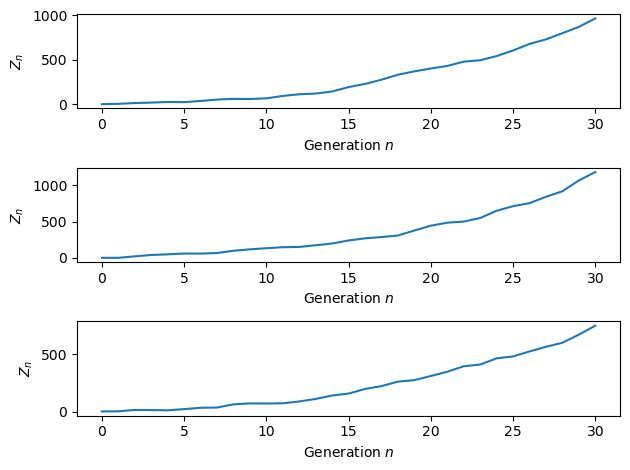

In [140]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

samples = np.random.choice(range(n_simulations), 3, replace=False)

for ax, sample in zip(axs.flatten(), samples):
    populations = [sum(immigration_population_results[sample][0][i]) for i in range(n_generations+1)]
    ax.plot(populations)
    
    ax.set_xlabel('Generation $n$')
    ax.set_ylabel('$Z_n$')

plt.savefig('simulated_immigration_pop.png')
plt.show()

We can see here that while we are experiencing exponential growth, it is a much messier version of growth and is not a smooth exponential curve. This makes sense as we are summing up very different random variables to determine our population at each subsequent generation.

Because of this, we might expect that $\hat{m}$, the MLE of the traditional Galton Watson Branching Process might not be very suitable here. In fact we know it isn't because that process doesn't account for immigration in its model. Let's look into the performance of that $\hat{m}$ now.

In [141]:
parent_counts = []
child_counts = []
for simulation in range(n_simulations):
    generation_counts = []
    for generation in range(n_generations):
        generation_counts.append(sum(immigration_population_results[simulation][0][generation]))
    parent_counts.append(sum(generation_counts[:-1]))
    child_counts.append(sum(generation_counts[1:]))

estimators = [child_counts[i] / parent_counts[i] for i in range(n_simulations)]

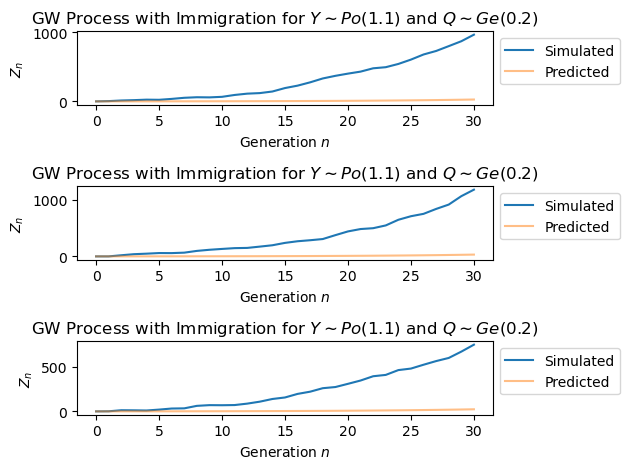

In [142]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

for ax, sample in zip(axs.flatten(), samples):
    populations = [sum(immigration_population_results[sample][0][i]) for i in range(n_generations+1)]
    ax.plot(populations, label='Simulated')
    
    x = np.arange(n_generations+1)
    predicted = list(map(lambda n: estimators[sample]**n, x))
    
    ax.plot(predicted, label='Predicted', alpha=0.5)
    
    ax.set_title(f'GW Process with Immigration for $Y \sim Po(1.1)$ and $Q \sim Ge(0.2)$')
    ax.set_ylabel('$Z_{n}$')
    ax.set_xlabel('Generation $n$')
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig('GW_immigration_process_with_predictions.png')
plt.show()

As expected the traditional MLE $\hat{\theta}$ did not work very well. It is interesting that it severely underestimates the population growth. This is likely because the expected number of immigrants is much higher than the expected number of offspring from reproduction for a given individual, stemming from their very different distributions.

Luckily there is a way to obtain a much better estimator for the case where there is immigration.

In their paper, Bhat and Adke are able to obtain the maximum likelihood estimators of the individual probabilities for both the reproduction and immigration distributions [6].

More specifically, if we let $p_j = P\left(X_{in} = j\right)$ be the probability that a given individual has $j$ offspring, and $q_k = P\left(Q_n = k\right)$ be the probability there are $k$ immigrants in a given generation, we can find the maximum likelihood estimators each each $p_j$ and $q_k$, $j, j = 0, 1, 2, \ldots$.

Their MLEs, denoted by $\hat{p_j}$ and $\hat{q_k}$ respectively are given by
$$
\hat{p_j} = \frac{N_j(n)}{\sum_{i = 1}^{n-1} Z_i}, \quad \hat{q_k} = \frac{M_k(n)}{n}
$$

where $N_j(n)$ is the number of parents having $j$ offspring in the first $n - 1$ generations of parents, and $M_k(n)$ is the number of times $k$ immigrants join a generation among the first $n$ generations.

i.e.
$$
N_j(n) = \sum_{i = 1}^{n-1} \sum_{l = 1}^{Z_{i}} I\left(X_{li} = j\right) \quad \text{and} \quad M_k(n) = \sum_{i = 1}^{n} I(Q_i = k)
$$

Moreover, they also found that if the means of the offspring and immigration distributions are finite, then there is an MLE for their means $m$ and $\mu$ respectively, as well, and they are given by

$$
\hat{m}_{offspring} = \sum_{i = 0}^{\infty} i \hat{p_i} \quad \text{and} \quad \hat{\mu}_{immigration} = \sum_{j = 0}^{\infty} j \hat{q_j}
$$
respectively.

From this we can obtain a more accurate model. First though let's examine the theoretical case.

The expected number of individuals in generation $n$ is simply 
$$
Z_{n-1}EY + EQ = Z_{n-1}m + q
$$
where $q = EQ$.

Let's build up a sequence of this to build our intution.

At generation 0 there is 1 individual.

In generation 1 we would expect there to be $m + q$ indvidiuals.

Then in generation 2 we would expect there to be $(m + q)m + q = m^2 + mq + q$ individuals.

So in generation 3 we would expect there to be $(m^2 + mq + q)m + q = m^3 + m^2q + mq + q$ individuals.

We can see the pattern here, so for any generation $n$ we would expect the number of indviduals to be
$$
q\sum_{i = 0}^{n} m^i
$$

Therefore, for our model we will use the analagous
$$
{\hat{\mu}}_{immigration}\sum_{i = 0}^{n} \hat{m}^i_{offspring}
$$
to predict the number of individals at generation $n$.

Let's use this model now.

In [143]:
p_i_estimators = [{i: immigration_population_results[simulation][1][i] / parent_counts[simulation] for i in immigration_population_results[simulation][1].keys()} for simulation in range(n_simulations)]
q_i_estimators = [{i: immigration_population_results[simulation][2][i] / n_generations for i in immigration_population_results[simulation][2].keys()} for _ in range(n_simulations)]

p_estimators = []
q_estimators = []
for simulation in range(n_simulations):
    e = 0
    for i, p in p_i_estimators[simulation].items():
        e += i*p
    p_estimators.append(e)
    e = 0
    for i, q in q_i_estimators[simulation].items():
        e += i*q
    q_estimators.append(e)

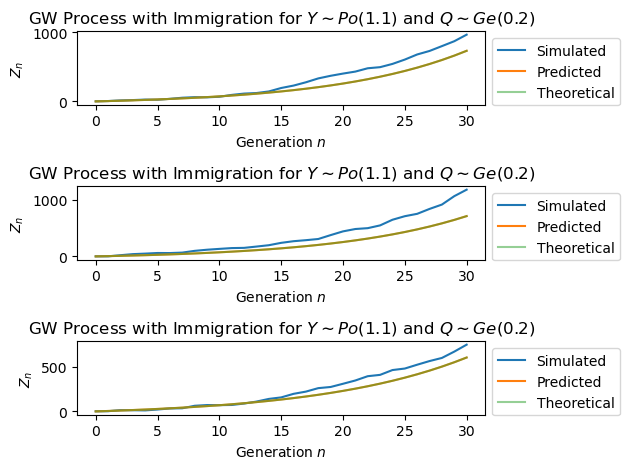

In [147]:
fig, axs = plt.subplots(3, 1, tight_layout=True)

def immigration_model_pred(n, m_hat, mu_hat):
    t = 0
    for i in range(n):
        t += m_hat**i
    return mu_hat*t

for ax, sample in zip(axs.flatten(), samples):
    populations = [sum(immigration_population_results[sample][0][i]) for i in range(n_generations+1)]
    ax.plot(populations, label='Simulated')
    
    x = np.arange(n_generations+1)
    predicted = list(map(lambda n: immigration_model_pred(n, p_estimators[sample], q_estimators[sample]), x))
    theoretical = list(map(lambda n: immigration_model_pred(n, 1.1, (1 - 0.2)/2), x))
    
    ax.plot(predicted, label='Predicted', alpha=1)
    ax.plot(predicted, label='Theoretical', alpha=0.5)
    
    ax.set_title(f'GW Process with Immigration for $Y \sim Po(1.1)$ and $Q \sim Ge(0.2)$')
    ax.set_ylabel('$Z_{n}$')
    ax.set_xlabel('Generation $n$')
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig('GW_immigration_process_with_good_predictions.png')
plt.show()

We can see that now our model is performing a lot better! And it is no surprise that the traditional GW model performed poorly. Recall that the traditional model has an estimator that assumes exponential growth, whereas what we have in actuality is polynomial growth, which is much slower in the long run, but for the first set of generations grows much faster.

From this it is clear that when dealing with populations involving immigration, a separate model is, unsurprisingly, needed to have an accurate model. However, despite its accuracy, there is a major downside to this model.

This model obtains its estimates for the population at a given generation from observations on every single $X_{in}$ and $Q_n$. That is, it requires you to know how many offspring each individual had for each generation, and how many immigrants there were for each generation.

In contrast to this, the traditional GW model only requires you know the total population at each generation to obtain an estimate, i.e. you need only know the $Z_i$s to obtain the appropriate MLE.

If there is a a reliable and accurate data collection method available, like a government census, then this may not be an issue. But in practice it can be very difficult to obtain all of these individual values, and it is much easier to simply know the total for each generation.

# Experiment with Real Data

Now that we have investigated a few models and methods for analyzing different kinds of data through the lens of a branching process, let's apply these techinqiues to real data!

We will be using data provided by the National Agriculture Statistics Service which has recorded the number of honeybee colonies in the United States annualy since 1987, giving us 36 years worth of data.

The goal is to use a branching process to understand the population of honeybees and predict trends into the future.

To begin with, let's look at the data.

In [193]:
df = pd.read_csv('~/Downloads/honeybee.csv')
df = df[['Year', 'Value']].rename(columns={'Value': 'Population'})
df['Population'] = df['Population'].apply(lambda x: ''.join(x.split(',')))
df = df.astype({'Population': int, 'Year': int})
df = df.sort_values(by='Year').reset_index(drop=True)
df

,Year,Population
0,1987,3316000
1,1988,3370000
2,1989,3528000
3,1990,3220000
4,1991,3211000
5,1992,3045000
6,1993,2875000
7,1994,2783000
8,1995,2655000
9,1996,2581000


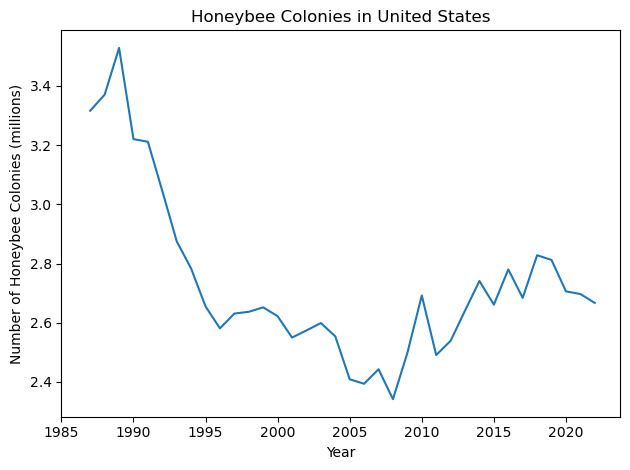

In [227]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(df.Year, df.Population/1e6)
ax.set_xticks(range(1985, 2023, 5))
ax.set_title('Honeybee Colonies in United States')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Honeybee Colonies (millions)')

plt.savefig('honeybee_population.png')
plt.show()

We can see that the Honeybee population has been declining since the late 80s, with a very sharp decrease up until the turn of the century in 2000. Since that it has seemed to remain a bit more stable.

Applying a branching process to this data is not entirely ideal because the data available is at a year to year basis, whereas the lifespan of a honeybee is on the order of weeks [7]. As such we do not have data corresponding to each generation, and instead have data for something like every 10 generations instead. Additionally, this data is showing the yearly number of honeybee colonies, not the number of honeybees themselves. This is akin to measuring the number of households in the United States versus the number of people in the United States, they are two similar but different items.

Nonetheless we will proceed with applying a branching process analysis to this data, but do not that it is not perfectly suited for this data (although in the real world it is often difficult to find perfectly suited data anyways).

To begin with, we must decide what kind of model to use. That is, should we use a traditional GW Branching Process model, a finite population model, or an immigration model?

Immediately we can rule out an immigration model because honeybees likely do not immigrate across countries and so there shouldn't be an immigration term in the honeybee colony population.

While there is obviously some finite carrying capacity of the environment for honeybees, recall that the estimator for the population at a subsequent generation is a function only of previous times at which there was the same population. Because we only have 36 data points, we do not have enough data to be able to provide a fully predictive model for the honeybee population. As such it is most appropriate to move forward with the traditional branching process analysis, though note that there are many caveats as noted above to applying this analysis here.

To begin with we will determine the maximum likelihood estimator $\hat{m}$ of the true average number of offspring per population member, where here a "population member" is a honeybee colony. Recall that for the traditional GW branching process that estimator is simply
$$
\hat{m} = \frac{\sum_{i=1}^n Z_i}{\sum_{i=0}^{n-1} Z_i}
$$

So if we let $Z_i$ be the number of honeybee colonies in year $i+1987$, then we would have that
$$
\hat{m} = \frac{\sum_{i=1}^{35} Z_i}{\sum_{i=0}^{34} Z_i}
$$

In [228]:
honeybee_m = df.loc[df.Year > df.Year.min(), 'Population'].sum() / df.loc[df.Year < df.Year.max(), 'Population'].sum()
print(honeybee_m)

0.993222710706864


Based on the data we get the estimate 
$$
\hat{m} = 0.9932
$$

Recalling that the expected population at generation $n$ is given by $m^n$, we can use this to model our the population of honeybees for any year after 1987 with one subtle adjustment. The result that $E\left(Z_n\right) = m^n$ relies on the fact that the initial population is 1, i.e. $Z_0 = 1$. We do not know the initial population of honeybees, but since we are defining $Z_0$ to be the population in 1987, we clearly do not have that $Z_0 = 1$, in fact we have $Z_0$ to be closer to 3.3 million.

Luckily there is a really simply solution. With a simple modification to the proof leading the above mentioned result, we can find that the more general version of the formula is
$$
E\left(Z_n\right) = Z_0\left(m\right)^n
$$

So with a simple GW model, we can model the honeybee colony population $n$ years after 1987 to be
$$
3.316 * 10^6 * 0.9932^n
$$

Let's do that now and see what our honeybee colony population will be.

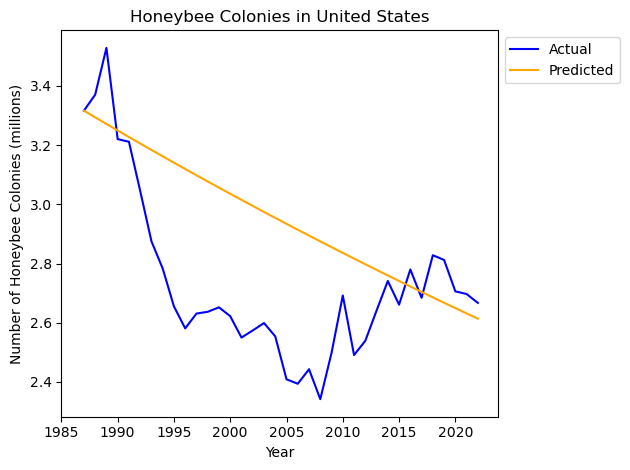

In [229]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(df.Year, df.Population/1e6, label='Actual', color='blue')

initial_pop = df.loc[df.Year == df.Year.min(), 'Population'].values[0]
preds = np.array([initial_pop * (honeybee_m ** (year - df.Year.min())) for year in df.Year.values]) / 1e6
ax.plot(df.Year, preds, label='Predicted', color='orange')

ax.set_xticks(range(1985, 2023, 5))
ax.set_title('Honeybee Colonies in United States')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Honeybee Colonies (millions)')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('honeybee_model.png')
plt.show()

So as expected the model does not fit quite accurately. This is likely because it is not extremely well suited for this data specifically as mentioned before. However there are at least 2 points worth mentioning.

The first is that the model is failing to accurately assess the nuance and year to year changes of the population and is only able to grasp the general trend. However it does this quite well, as noted by the fact that it has a fairly accurate prediction for 2015 onwards. More on this later.

The second point worth mentioning is that the model is predicting a decline in honeybee colony population. This makes sense given there has actually been a decline in the population. The observant reader could have noticed this earlier because the traditional GW branching process will model the population as an exponential function, and so if the base of the exponent, which in this case is $\hat{m}$ is below 1, then there will be exponential decay of the population. This is exactly what we have with this data.

Moreover, if the true value for $m$ is below 1, then as mentioned by Watson in his original paper, and later as noted by Athreya and Ney [8], in expectation the population will become extinct. This is an importanat realization because then this model (albeit not the best one) would predict the extinction of honeybees.

As mentioned earlier though, the model seems to do a fairly poor job of modeling the honeybee population between the years of 1990 and 2010. As mentioned earlier, there are two very different and distinct trends in the population of honeybee colonies. One trend which goes from about 1987-2008, and another from 2009-2022, representing a period of sharp decline, and steady rise in the population respectively.

If we instead apply 2 separate traditional GW models to the data we may get a more accurate trend, though this begins to get closer to overfitting to the data so that is worth being aware of.

In this case we would need two estimators $\hat{m_1}$ and $\hat{m_2}$ which are the maximum likelihood estimators for the true average number of offspring per population member from 1987-2008 and 2009-2020 respectively.

Then we would have the estimate for the population $n$ years after 1987, $\hat{Z_n}$ be
$$
\hat{Z_n} = \left\{
\begin{split}
    &Z_0 \left(\hat{m_1}\right)^{n} \quad &n < 22 \\
    &Z_{22} \left(\hat{m_2}\right)^{n-22} \quad &n \ge 22 
\end{split}
\right.
$$

Let's calculate $\hat{m_1}$ and $\hat{m_2}$ now.

In [230]:
df1 = df.loc[df.Year < 2009]
df2 = df.loc[df.Year >= 2009]
honeybee_m1 = df1.loc[df1.Year > df1.Year.min(), 'Population'].sum() / df1.loc[df1.Year < df1.Year.max(), 'Population'].sum()
honeybee_m2 = df2.loc[df2.Year > df2.Year.min(), 'Population'].sum() / df2.loc[df2.Year < df2.Year.max(), 'Population'].sum()
print(honeybee_m1, honeybee_m2)

initial_pop1 = df1.loc[df1.Year == df1.Year.min(), 'Population'].values[0]
initial_pop2 = df2.loc[df2.Year == df2.Year.min(), 'Population'].values[0]
print(initial_pop1, initial_pop2)

0.9833927262186909 1.0048605119355767
3316000 2498000


Doing the calculation we get $\hat{m_1} = 0.9834$ and $\hat{m_2} = 1.005$. Giving us the following model for our population $n$ years after 1987
$$
\hat{Z_n} = \left\{
\begin{split}
    &3.316 * 10^6 (0.9834)^{n} \quad &n < 22 \\
    &2.498 * 10^6 (1.005)^{n-22} \quad &n \ge 22 
\end{split}
\right.
$$

Let's plot this model now and compare it to the original model.

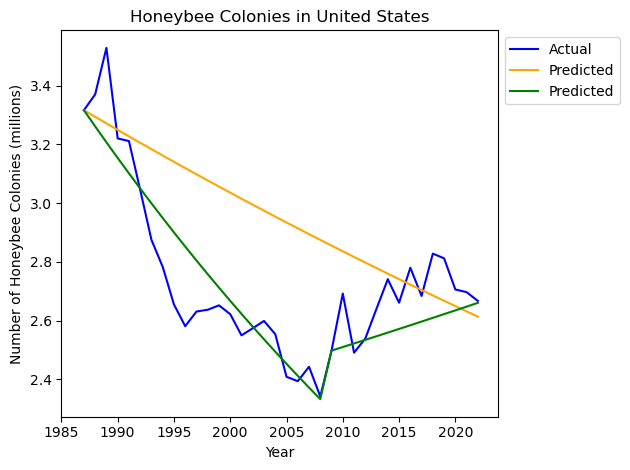

In [231]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(df.Year, df.Population/1e6, label='Actual', color='blue')

initial_pop = df.loc[df.Year == df.Year.min(), 'Population'].values[0]
preds_orig = np.array([initial_pop * (honeybee_m ** (year - df.Year.min())) for year in df.Year.values]) / 1e6
ax.plot(df.Year, preds_orig, label='Predicted', color='orange')

preds_new = [initial_pop1 * (honeybee_m1 ** (year - df1.Year.min())) for year in df1.Year.values]
preds_new += [initial_pop2 * (honeybee_m2 ** (year - df2.Year.min())) for year in df2.Year.values]
preds_new = np.array(preds_new) / 1e6
ax.plot(df.Year, preds_new, label='Predicted', color='green')

ax.set_xticks(range(1985, 2023, 5))
ax.set_title('Honeybee Colonies in United States')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Honeybee Colonies (millions)')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('honeybee_model_split.png')
plt.show()

This is a much more accurate model! We could further split into even more time periods, but then we run into the risk of overfitting our model so it is best to not do this, but it does seem appropriate to use the 2 model approach compared to the original 1 model approach based on the data and observed trends here, as they really seem to be 2 separate processes happening.

The main takeaway is that while honeybee populations have been in decline overall, it seems like recent trends could indicate that there is positive growth ahead and that the population in the United States could rebound. However please do be aware of all of the caveats in this analysis mentioend earlier and there are likely better methods than a simple GW process that one could apply to this data here.

Ideally incorporating a carrying capacity model would be ideal but there is not enough data for that. Additionally we only have data for about every 10 generations because the data is yearly and honeybees have a lifespan on the order of 6 weeks typically, so this isn't an entirely accurate model, but nonetheless can be used to draw basic conclusions.

# Conclusion and Wrap Up

Hopefully after going through this, branching processes, and their more complex and general derivations that incorporate other phenomena into the models make more sense, not just mathematically but also intuitively. While they may appear to be very complicated, at their core branching processes are a very simple concept, which allows them to explain and be used in application with myriad types of data, and more importantly they are something anyone can understand and use if they only put in the effort to understand them, which hopefully this is able to aid with.

They can help answer the questions of population extinction or persistance across many generations of time and in certain cases can help to predict and model these populations across time just like more commonly known methods such as linear regression, but without many of the assumptions that come with such a model.

To conclude, Branching Processes are just another item in one's mathematical toolbox they can use to solve a problem and answer a question when the conditions are right. So please consider using them in the future and be mindful of the bees, let's keep them and other animals alive.

# Bibliography

[1] W. Feller, "Extinction Probabilities in Branching Processes," in Mathematical Demography, 1977, pp. 407-409.

[2] N. Keiding and S. L. Lauritzen, "Marginal Maximum Likelihood Estimates and Estimation of the Offspring Mean in a Branching Process," Scandanavian Journal of Statistics, vol. 5, pp. 106-110, 1978. 

[3] G. Högnäs, "On the lifetime of a size-dependent branching process," Stochastic Models, 2019. 

[4] P. Braunsteins, S. Hautphenne and C. Minuesa, Parameter estimation in branching processes with almost sure extinction, 2020. 

[5] B. R. Bhat and S. R. Adke, "Maximum Likelihood Estimation for Branching Processes with Immigration," Advances in Applied Probability, vol. 13, no. 3, pp. 498-509, 1981. 

[6] National Agricultural Statistics Service, USDA, "United States Department of Agriculture National Agricultural Statistics Service," 2023. [Online]. Available: https://www.nass.usda.gov/. [Accessed 20 August 2023].

[7] Orkin, "Honey Bee Life Span," Orkin, 2023. [Online]. Available: https://www.orkin.com/pests/stinging-pests/bees/honey-bees/honey-bee-life-span. [Accessed 20 August 2023].

[8] K. B. Athreya and P. E. Ney, "T. E. HARRIS AND BRANCHING PROCESSES," The Annals of Probability, vol. 39, no. 2, pp. 429-434, 2011. 